<a target="_blank" href="https://colab.research.google.com/github/lamm-mit/ProteinMechanicsDiffusionDesign/blob/main/notebook_for_colab/pLDM_inference_standalone_colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 0. Preparation:
### 0-1. Add packages

In [1]:
#@title ####For omegafold

import os,sys
import math

# ++ Model is hosted on HG
from huggingface_hub import hf_hub_download
from huggingface_hub import snapshot_download

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #turn off CUDA if needed
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


comm_line=f'pip uninstall -y torch torchvision torchaudio torchdata torchtext fastai'
print(os.popen(comm_line).read())
comm_line=f'pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113'
print(os.popen(comm_line).read())
import torch
print('Torch version: ', torch.__version__)

path_1 = '/opt/bin/'
dssp_file = path_1+'mkdssp'

file_exists = os.path.exists(dssp_file)
if not (file_exists):
  print('\033[1;32m For the 1st run, ')
  # ==============================================
  print('a. Install omegafold...')
  # install omegafold
  # ref: https://github.com/HeliXonProtein/OmegaFold
  !pip install git+https://github.com/HeliXonProtein/OmegaFold.git

  # time-consuming step:
  # Downloading weights from https://helixon.s3.amazonaws.com/release1.pt to /root/.cache/omegafold_ckpt/model.pt
  !mkdir /root/.cache/omegafold_ckpt
  !wget https://helixon.s3.amazonaws.com/release1.pt -O /root/.cache/omegafold_ckpt/model.pt

  print('b. Install DSSP...')
  # download an mkdssp
  # ==============================================
  # download things
  #
  hf_hub_download(
    repo_id="lamm-mit/ProteinMechanicsDiffusionDesign",
    filename="Model_files/mkdssp",
    local_dir='/content',
    local_dir_use_symlinks=False,
    revision='main'
  )
  # move the file
  print(os.popen(f"mv /content/Model_files/mkdssp {dssp_file}").read())

  #
  !chmod u+x /opt/bin/mkdssp

else:
  print('This is not the first run... ')

Found existing installation: torch 2.2.1+cu121
Uninstalling torch-2.2.1+cu121:
  Successfully uninstalled torch-2.2.1+cu121
Found existing installation: torchvision 0.17.1+cu121
Uninstalling torchvision-0.17.1+cu121:
  Successfully uninstalled torchvision-0.17.1+cu121
Found existing installation: torchaudio 2.2.1+cu121
Uninstalling torchaudio-2.2.1+cu121:
  Successfully uninstalled torchaudio-2.2.1+cu121
Found existing installation: torchdata 0.7.1
Uninstalling torchdata-0.7.1:
  Successfully uninstalled torchdata-0.7.1
Found existing installation: torchtext 0.17.1
Uninstalling torchtext-0.17.1:
  Successfully uninstalled torchtext-0.17.1
Found existing installation: fastai 2.7.14
Uninstalling fastai-2.7.14:
  Successfully uninstalled fastai-2.7.14

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 64.6 MB/s eta 0:00:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mkdssp:   0%|          | 0.00/13.4M [00:00<?, ?B/s]

In [2]:
#@title ####For other pip packages
# add some packages
try:
  print('\033[1;32m a. on Biopython...')
  from Bio.PDB import PDBParser
except ImportError as e:
  print(os.popen('pip install biopython').read())

try:
  print('\033[1;32m b. on kornia...')
  import kornia.augmentation
except ImportError as e:
  print(os.popen('pip install kornia').read())

try:
  print('\033[1;32m c. on einops...')
  from einops import rearrange, repeat, reduce
except ImportError as e:
  print(os.popen('pip install einops').read())

try:
  from einops_exts import rearrange_many, repeat_many, check_shape
except ImportError as e:
  print(os.popen('pip install einops-exts').read())

try:
  import pytorch_warmup as warmup
except ImportError as e:
  print(os.popen('pip install pytorch-warmup').read())

try:
  from ema_pytorch import EMA
except ImportError as e:
  print(os.popen('pip install ema-pytorch').read())

try:
  from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs
except ImportError as e:
  print(os.popen('pip install accelerate').read())

try:
  import py3Dmol
except ImportError as e:
  print(os.popen('pip install py3Dmol').read())

# added
try:
  import esm
except ImportError as e:
  print(os.popen('pip install fair-esm').read())

try:
  import torchinfo
except ImportError as e:
  print(os.popen('pip install torchinfo').read())

 a. on Biopython...
 b. on kornia...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.7 MB/s eta 0:00:00

 c. on einops...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.7/903.7 kB 11.5 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.6 MB/s eta 0:00:00




### 0.2. copy src from github

In [3]:
#@title #### Model code

import json, time, os, sys, glob

# ===================================================================
# from LAMM
# real one
pLDM_repo = 'https://github.com/lamm-mit/ProteinMechanicsDiffusionDesign.git'

pLDM_dir = '/content/ProteinMechanicsDiffusionDesign/'
#
if not os.path.isdir(pLDM_dir):
  os.system(f"git clone -q {pLDM_repo}")
sys.path.append(pLDM_dir)
#
# check
if not os.path.isdir(pLDM_dir):
  print(f"The package is not downloaded propertly. Check your access to the repository {pLDM_repo}")

In [4]:
#@title #### Small test
# a slient test
#
import PD_pLMProbXDiff.UtilityPack as UtilityPack
import PD_pLMProbXDiff.DataSetPack as DataSetPack
import PD_pLMProbXDiff.ModelPack as ModelPack
import PD_pLMProbXDiff.TrainerPack as TrainerPack
import PD_pLMProbXDiff.PostMDPack as PostMDPack
print('pLMP package is found now.')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

identify the device independently cuda:0
pLMP package is found now.


### 0.3. Download the model files

In [5]:
#@title #### Set up the saved model

# just script, no install is used
this_working_path = '/content/working_results/'

if not os.path.isdir(this_working_path):
  print('Creating working path...')
  print(os.popen('mkdir '+this_working_path).read())
  print('Done.')
  print('Downing files...')

this_file = this_working_path+'model_pack.pickle'
file_exists = os.path.exists(this_file)
if not (file_exists):
  # download things
  temp_name='model_pack.pickle'
  hf_hub_download(
    repo_id="lamm-mit/ProteinMechanicsDiffusionDesign",
    filename=f"Model_files/{temp_name}",
    local_dir='/content',
    local_dir_use_symlinks=False,
    revision='main'
  )
  cmd_line = f"mv /content/Model_files/{temp_name} {this_file}"
  print(os.popen(cmd_line).read())

#
this_file = this_working_path+'data_pack.pickle'
file_exists = os.path.exists(this_file)
if not (file_exists):
  # # download things
  temp_name='data_pack.pickle'
  hf_hub_download(
    repo_id="lamm-mit/ProteinMechanicsDiffusionDesign",
    filename=f"Model_files/{temp_name}",
    local_dir='/content',
    local_dir_use_symlinks=False,
    revision='main'
  )
  cmd_line = f"mv /content/Model_files/{temp_name} {this_file}"
  print(os.popen(cmd_line).read())

# add for dataset part
this_temp_path = this_working_path+'0_dataprocess_MD/'
if not os.path.isdir(this_temp_path):
  print('Creating data path...')
  print(os.popen('mkdir '+this_temp_path).read())
  print('Done.')
  print('Downing files...')
# add file if needed
#
this_file = this_working_path+'0_dataprocess_MD/'+'ForTest_LE_128_From_F1_f5.pt'
file_exists = os.path.exists(this_file)
if not (file_exists):
  # download things
  temp_name='ForTest_LE_128_From_F1_f5.pk'
  hf_hub_download(
    repo_id="lamm-mit/ProteinMechanicsDiffusionDesign",
    filename=f"Model_files/{temp_name}",
    local_dir='/content',
    local_dir_use_symlinks=False,
    revision='main'
  )
  cmd_line = f"mv /content/Model_files/{temp_name} {this_file}"
  print(os.popen(cmd_line).read())


# add for model part
this_temp_path = this_working_path+'1_model_SS/'
if not os.path.isdir(this_temp_path):
  print('Creating model path...')
  print(os.popen('mkdir '+this_temp_path).read())
  print('Done.')
  print('Downing files...')
# add file if needed
#
this_file = this_working_path+'1_model_SS/'+'trainer_save-model_pLDM.pt'
file_exists = os.path.exists(this_file)
if not (file_exists):
  # download things
  temp_name='trainer_save-model_pLDM.pt'
  hf_hub_download(
    repo_id="lamm-mit/ProteinMechanicsDiffusionDesign",
    filename=f"Model_files/{temp_name}",
    local_dir='/content',
    local_dir_use_symlinks=False,
    revision='main'
  )
  cmd_line = f"mv /content/Model_files/{temp_name} {this_file}"
  print(os.popen(cmd_line).read())

Creating working path...

Done.
Downing files...


model_pack.pickle:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

data_pack.pickle:   0%|          | 0.00/10.5M [00:00<?, ?B/s]


Creating data path...

Done.
Downing files...


Model_files/ForTest_LE_128_From_F1_f5.pk:   0%|          | 0.00/168k [00:00<?, ?B/s]


Creating model path...

Done.
Downing files...


trainer_save-model_pLDM.pt:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

## 1. Working part

In [6]:
#@title ### 1.0. Check the floor
import os, sys
print('Here is : \n', os.popen('pwd').read())
print('What we get in hardware: \n', os.popen('nvidia-smi').read())

import torch
print("What we have in software: \n Torch version:", torch.__version__)
print('Python: ', sys.version) # no switch case code
print()

import torch
print("What we have in software: \n Torch version:", torch.__version__)
print('Python: ', sys.version) # no switch case code
print()

print('What hardware the software see:')
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
print(device)
num_of_gpus = torch.cuda.device_count()
print("# of GPU", num_of_gpus)
print()
torch.cuda.empty_cache()

Here is : 
 /content

What we get in hardware: 
 Wed Apr 17 04:07:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+------------------

In [7]:
#@title ### 1.1. Setup the problem
# prepare for package debugging
# for debug
import importlib
import json
import matplotlib.pyplot as plt

# ===============================================
# Global control key setup
# ===============================================
# Control keys:
# This one will be directly modified for each task
CKeys = dict(
    #
    Running_Type=2, # 1-local:engaging cluster, 2-supercould cluster, 3-google colab, 4-local ubuntu
    #
    # Working_Mode=1, # 1-training, 2-sampling for test
    Working_Mode=2,
    #
    # IF_FirstRun=1,  # 1-1st run of training; otherwise, # of training run
    IF_FirstRun=2,  # 1-1st run of training; otherwise, # of training run
    #
    # 1-SecStr-ModelB, 2-MD-ModelB, 3-SecStr-ModelA, 4-MD-ModelA
    # 5-SecStr-ModelB-Embdding, 6-MD-ModelB, 7-SecStr-ModelA-pLM, 8-MD-ModelA
    # 9-MD-Predictor-ModelB, 10-
    # 11-MD-ModelB
    Problem_ID=11, # 8, # 6,
    #
    # Debug=1, # 1-debug mode on; add more debug keys for different blocks
    Debug=0, # 1-debug mode on; add more debug keys for different blocks
    #
    Debug_DataSet=1,
    Debug_Model=1
    #
    # Debug=0
)

if CKeys['Debug']==1:
    # add some
    CKeys['SlientRun']=0 # 1-save figure into files; 0-show figures
    # detailed debug keys
    # 1. for model dimension
    CKeys['Debug_DataPack']=1
    CKeys['Debug_ModelPack']=1
    CKeys['Debug_TrainerPack']=1
    # 2. for trainer part
    CKeys['Debug_DataPack']=1
    CKeys['Debug_ModelPack']=0
    CKeys['Debug_TrainerPack']=3
    # #
    # CKeys['testratio']=0.15 # for small ForcPath problem
    CKeys['testratio']=0.10 # for large ForcPath problem

else:
    # for real working run
    CKeys['SlientRun']=1
    #
    CKeys['Debug_DataPack'] = 0
    CKeys['Debug_ModelPack'] = 0
    CKeys['Debug_TrainerPack'] = 0 # 2 # 1
    # add some for training
    CKeys['epochs'] = 4000-3250 # 1000 # 200
    CKeys['print_loss_every_this_epochs']=50 # 5
    CKeys['sample_every_this_epochs']=100 # 50 # 20
    CKeys['save_model_every_this_epochs']=50 # 20
    # #
    #
    # CKeys['testratio']=0.15 # for small ForcPath problem
    CKeys['testratio']=0.10 # for large ForcPath problem
    #

# for check
print(json.dumps(CKeys, indent=4))


# Problem type:
print('Problem type: ', CKeys['Problem_ID'])
print('Debug mode: ', CKeys['Debug'])
print('Working mode: ', CKeys['Working_Mode'])


# ===========================================================
# Parameter key:
# ===========================================================
#
PKeys = {}
# define this one according the running environment
# add more if needed
#
#
root_path = '/home/gridsan/bni/Test_ground/jupyter/1_git_project/sort_pdb_database_0/Local_Store/'
if CKeys['Debug']==1:
    # PKeys['prefix']='../Local_Store/For_16_0/'
    # use the absolute path for transformability
    PKeys['prefix']=root_path+'For_20_0/'

if CKeys['Debug']!=1:
    # add one for google colab
    PKeys['prefix']=this_working_path # '/content/11_pLMProb_Diff_SMD_ModelB_embed_640/0_Training/'

# store the data pack after processing
PKeys['pk_data_pack']=PKeys['prefix']+'data_pack.pickle'
PKeys['pk_model_pack']=PKeys['prefix']+'model_pack.pickle'

#
# clean EVERYTHING in the dir if 1st
#
if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1:
    if os.path.exists(PKeys['prefix']):
        cmd_line=f"rm -r {PKeys['prefix']}"
        print("clean the slade...")
        print(f"excute {cmd_line}")
        os.popen(cmd_line).read()
        #
    # create dir for working space
    UtilityPack.create_path(PKeys['prefix'])
# ========================================================================
# prepare the csv files
# ========================================================================

if CKeys['Problem_ID']==1 or CKeys['Problem_ID']==3 \
or CKeys['Problem_ID']==5 or CKeys['Problem_ID']==7:
    SS_csv_file = root_path+'Local_Store/'+'PROTEIN_Mar18_2022_SECSTR_ALL.csv'

if CKeys['Problem_ID']==2 or CKeys['Problem_ID']==4 \
or CKeys['Problem_ID']==6 or CKeys['Problem_ID']==8 \
or CKeys['Problem_ID']==11:

    # first debug with LE_64, to be update into LE_128
    MD_smo_csv_file = root_path+'For_1/ForTrain_recon_BSDB_LE_64_smd_disp_forc_df_smo.csv'

    # into LE_128
    MD_smo_pk_file  = root_path+'For_1/ForTrain_recon_BSDB_LE_128_smd_disp_forc_df_smo.pk'

{
    "Running_Type": 2,
    "Working_Mode": 2,
    "IF_FirstRun": 2,
    "Problem_ID": 11,
    "Debug": 0,
    "Debug_DataSet": 1,
    "Debug_Model": 1,
    "SlientRun": 1,
    "Debug_DataPack": 0,
    "Debug_ModelPack": 0,
    "Debug_TrainerPack": 0,
    "epochs": 750,
    "print_loss_every_this_epochs": 50,
    "sample_every_this_epochs": 100,
    "save_model_every_this_epochs": 50,
    "testratio": 0.1
}
Problem type:  11
Debug mode:  0
Working mode:  2


In [8]:
#@title ### 1.2. Handle the dataset

import pickle
import numpy as np
import pandas as pd

print('On Problem: ', CKeys['Problem_ID'])
print(this_working_path)

# ====================================================
# add some new keys for dataset
# ====================================================
# for data washing: only for 1st training cycle
if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1:

    if CKeys['Problem_ID']==1:
        pass

    elif CKeys['Problem_ID']==2:
        pass
        print("2")

    elif CKeys['Problem_ID']==3:
        pass


    elif CKeys['Problem_ID']==4:
        pass


    # /////////////////////////////////////////////////////////////
    # try embedding
    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    elif CKeys['Problem_ID']==5:
        pass

    #
    elif CKeys['Problem_ID']==6:
        pass


    elif CKeys['Problem_ID']==7:
        pass


    elif CKeys['Problem_ID']==8:
        #
        pass

    elif CKeys['Problem_ID']==11:
        # copied from Problem_ID=6
        #
        print("11, input MD ForcePath, output AA sequence")
        # ++++++++++++++++++++++++++++++++++++++
        # MD record as the tokenized input seq
        #
        # try to convey all para via one key
        DataKeys={}
        # ======================================
        # keys for "screen_dataset_MD"
        DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_MD/'
        # add the folder
        UtilityPack.create_path(DataKeys['data_dir'])

        # screening rules
        DataKeys['min_AA_seq_len']=0
        # DataKeys['max_AA_seq_len']=64
        DataKeys['max_AA_seq_len']=128
        DataKeys['max_Force_cap']=1000

        # ++++++++++++++++++++++++++++++++++++++
        df_raw, protein_df = DataSetPack.screen_dataset_MD(
            csv_file=None,
            pk_file=MD_smo_pk_file,
            PKeys=DataKeys, # to be updated
            CKeys=CKeys,
        )

        # save the dataframe
        pd.to_pickle(protein_df, DataKeys['data_dir']+'protein_df.pk')
        pd.to_pickle(df_raw, DataKeys['data_dir']+'df_raw.pk')

        # ======================================
        # keys for 2nd function
        DataKeys['X_Key']='sample_FORCEpN_data' # or 'Max_Smo_Force'
        #
        DataKeys['tokenizer_X']=None # will not be used
        DataKeys['tokenizer_y']=None # to be created
        # think about this: update this one if necessary
        # DataKeys['Xnormfac'] = np.max(protein_df['Max_Smo_Force'])
        DataKeys['Xnormfac'] = 750.

        print('Normalization factor for force: ', DataKeys['Xnormfac'])
        DataKeys['ynormfac']=1. # not used as esm is used # 21. # old force diffusion model 22.
        #
        DataKeys['batch_size']=256
        DataKeys['testset_ratio']=0.15
        DataKeys['maxdata']=99999999991000
        # ++ for pLM
        # for AA embending using ESM
        DataKeys['ESM-2_Model']='esm2_t33_650M_UR50D'
        # add for embedding space
        # DataKeys['image_channels']=1280
        #
        # DataKeys['ESM-2_Model']='esm2_t12_35M_UR50D'
        # # DataKeys['image_channels']=480
        #
        # DataKeys['ESM-2_Model']='esm2_t36_3B_UR50D'
        # DataKeys['image_channels']=2560
        #
        DataKeys['ESM-2_Model']='esm2_t30_150M_UR50D'
        # DataKeys['image_channels']=640

        # only use the probability part
        DataKeys['image_channels']=33

    else:
        print('No Problem Type found...')

print(CKeys)


# ====================================================
# convert into datasets
# ====================================================
if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1:
    if CKeys['Problem_ID']==1:
        pass


    elif CKeys['Problem_ID']==2:
        pass


    elif CKeys['Problem_ID']==3:
        pass


    elif CKeys['Problem_ID']==4:
        pass


    # ///////////////////////////////////////////////////////////////
    #  add embedding cases
    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    elif CKeys['Problem_ID']==5:
        pass


    # add if needed
    elif CKeys['Problem_ID']==6:
        pass

    elif CKeys['Problem_ID']==7:
        pass


    elif CKeys['Problem_ID']==8:
        pass

    elif CKeys['Problem_ID']==11:

        train_loader, \
        train_loader_noshuffle, \
        test_loader, \
        tokenizer_y, \
        tokenizer_X = DataSetPack.load_data_set_from_df_SMD_pLM(
                protein_df,
                PKeys=DataKeys, # to be updated
                CKeys=CKeys,
            )

    elif CKeys['Problem_ID']==12:
        pass

    else:
        print('No Problem Type found...')

    print("==========================================")
    print("Save the datasets ...")
    print("==========================================")
    # save the dataset for for the 1st run
    data_pack = {}
    data_pack['train_loader']=train_loader
    data_pack['train_loader_noshuffle']=train_loader_noshuffle
    data_pack['test_loader']=test_loader
    data_pack['tokenizer_X']=tokenizer_X
    data_pack['tokenizer_y']=tokenizer_y
    # keys
    data_pack['DataKeys']=DataKeys
    # data_pack['CKeys']=CKeys
    data_pack['PKeys']=PKeys
    with open(PKeys['pk_data_pack'], 'wb') as handle:
        pickle.dump(data_pack, handle, protocol=pickle.HIGHEST_PROTOCOL)

else: # work both for training and testing

    print('This is not the first run')
    print('Load back in the data packages...')
    with open(PKeys['pk_data_pack'], 'rb') as handle:
        data_pack = pickle.load(handle)
    # deliver the results
    train_loader=data_pack['train_loader']
    train_loader_noshuffle=data_pack['train_loader_noshuffle']
    test_loader=data_pack['test_loader']
    tokenizer_X=data_pack['tokenizer_X']
    tokenizer_y=data_pack['tokenizer_y']
    # keys (create or update)
    DataKeys=data_pack['DataKeys']
    # ++ for colab, need to update the path part
    DataKeys['data_dir']=this_working_path+'0_dataprocess_MD/'
    # ++
    # CKeys=data_pack['CKeys']
    PKeys=data_pack['PKeys']
    # ++ for colab, need to update the path part
    PKeys['prefix']=this_working_path
    PKeys['pk_data_pack']=this_working_path+'data_pack.pickle'
    PKeys['pk_model_pack']=this_working_path+'model_pack.pickle'
    # ++
    # add some for specific problem
    if CKeys['Problem_ID']==2 or CKeys['Problem_ID']==6 \
    or CKeys['Problem_ID']==11:
        pass

    print('Done.')


print(DataKeys)
print(this_working_path)

On Problem:  11
/content/working_results/
{'Running_Type': 2, 'Working_Mode': 2, 'IF_FirstRun': 2, 'Problem_ID': 11, 'Debug': 0, 'Debug_DataSet': 1, 'Debug_Model': 1, 'SlientRun': 1, 'Debug_DataPack': 0, 'Debug_ModelPack': 0, 'Debug_TrainerPack': 0, 'epochs': 750, 'print_loss_every_this_epochs': 50, 'sample_every_this_epochs': 100, 'save_model_every_this_epochs': 50, 'testratio': 0.1}
This is not the first run
Load back in the data packages...
Done.
{'data_dir': '/content/working_results/0_dataprocess_MD/', 'min_AA_seq_len': 0, 'max_AA_seq_len': 128, 'max_Force_cap': 1000, 'X_Key': 'sample_FORCEpN_data', 'tokenizer_X': None, 'tokenizer_y': None, 'Xnormfac': 750.0, 'ynormfac': 1.0, 'batch_size': 256, 'testset_ratio': 0.15, 'maxdata': 99999999991000, 'ESM-2_Model': 'esm2_t30_150M_UR50D', 'image_channels': 33}
/content/working_results/


In [9]:
#@title ### 1.2.1 Prepare for de novo conditions

# add a block to handle the De Novo force shape
# idea: pick to to mix them

# if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1 and CKeys['Problem_ID']==2:
if CKeys['Working_Mode']==1 and CKeys['Problem_ID']==2:
    print( protein_df.keys() )
    pass

elif CKeys['Working_Mode']==1 and CKeys['Problem_ID']==5:
    #
    pass
    #
elif CKeys['Working_Mode']==1 and CKeys['Problem_ID']==6:
    print( protein_df.keys() )
    pass

elif CKeys['Working_Mode']==1 and CKeys['Problem_ID']==11:
    # skipped: only for inference
    pass

# a quick check
print('tokenizer_X: ', tokenizer_X)
print('tokenizer_y: ', tokenizer_y)
print('Xnormfac: ', DataKeys['Xnormfac'])
print('ynormfac: ', DataKeys['ynormfac'])

if CKeys['Debug']==1:

    if CKeys['Debug_DataPack']==1:
        # uppack to check
        print('Len of train loader:', len(train_loader))
        print('Len of test loader:', len(test_loader))
        ii=-1
        # for item in train_loader:
        for item in test_loader:
            ii += 1
            if ii<1:
                print('Len of 1st batch item: ', len(item))
                this_item = item
            else:
                pass

        # on mini-batch
        print('Batch size: ', DataKeys['batch_size'])
        print('Seq len: ', DataKeys['max_AA_seq_len'])
        print('X.dim: ', this_item[0].shape) # Condition: (Batch, Condi)
        print('y_data.dim: ', this_item[1].shape) # AASequenc: (Batch, AACode)
        #

        print(this_item[0][0,:])

if CKeys['Debug']==1:

    if CKeys['Debug_DataPack']==1:

        if CKeys['Problem_ID']==8 or CKeys['Problem_ID']==7:

            print (this_item[0][0,:])
            print (this_item[0][0,:]*DataKeys['Xnormfac'])

tokenizer_X:  None
tokenizer_y:  None
Xnormfac:  750.0
ynormfac:  1.0


In [10]:
#@title ### 1.3 Model building

if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1:
    # this is a trining mode
    if CKeys['Problem_ID']==1:
        pass


    elif CKeys['Problem_ID']==2:
        pass


    elif CKeys['Problem_ID']==3:
        pass


    elif CKeys['Problem_ID']==4:
        pass


    elif CKeys['Problem_ID']==5:
        pass



    elif CKeys['Problem_ID']==6:
        pass

    elif CKeys['Problem_ID']==7:
        pass


    elif CKeys['Problem_ID']==8:
        pass

    elif CKeys['Problem_ID']==11:
        # =====================================================
        # ForcePath --> AA sequence
        # =====================================================
        #
        # this is 1st run....
        # +++++++++++++++++++++++++++++++++++++
        # ForcPath as input seq
        ModelKeys={}
        # storage
        ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
        # create the folder
        print("Creating the model dir...")
        UtilityPack.create_path(ModelKeys['model_dir'])
        # secondary folders
        ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
        UtilityPack.create_path(ModelKeys['model_dir_sample'])
        ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
        UtilityPack.create_path(ModelKeys['model_dir_model'])

        # for UNet
        ModelKeys['dim']=256    # dim for UNet
        ModelKeys['text_embed_dim'] = 512
        ModelKeys['embed_dim_position']=32
        ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
        ModelKeys['cond_dim'] = 512
        ModelKeys['cond_images_channels']=DataKeys['image_channels'] # 1
        ModelKeys['max_text_len']=DataKeys['max_AA_seq_len'] # this is about text condi
        # for Imagen
        ModelKeys['pred_dim']=DataKeys['image_channels'] # 1 # for sequence, =1
        ModelKeys['diff_timesteps']=(96,)
        ModelKeys['loss_type']=0 # MSE
        ModelKeys['elucidated']=True #
        ModelKeys['padding_idx']=0
        ModelKeys['max_length']=DataKeys['max_AA_seq_len'] # max seq len
        ModelKeys['device']=device
        #
        # buckets for Model building
        ModelKeys['UNet']={}
        ModelKeys['Imagen']={}
        # ++++++++++++++++++++++++++++++++++++++++++++++++++
        write_PK_UNet=dict()
        write_PK_UNet['dim']=ModelKeys['dim'] # 256
        write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim'] # 512+32
        write_PK_UNet['num_resnet_blocks']=1
        write_PK_UNet['cond_dim']=ModelKeys['cond_dim']  #this is where text embeddings are projected to...
        # write_PK_UNet['num_image_tokens']=None # using the default value
        # write_PK_UNet['num_time_tokens']=None  # using the default
        # write_PK_UNet['learned_sinu_pos_emb_dim']=None
        # write_PK_UNet['out_dim']=None
        write_PK_UNet['dim_mults']=(1, 2, 4, 8)

        write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
        write_PK_UNet['channels']=DataKeys['image_channels'] # 1
        write_PK_UNet['channels_out']=DataKeys['image_channels'] # 1

        write_PK_UNet['attn_dim_head']=64
        write_PK_UNet['attn_heads']=8
        write_PK_UNet['ff_mult']=2.
        write_PK_UNet['lowres_cond']=False  # for cascading diffusion - https://cascaded-diffusion.github.io/

        write_PK_UNet['layer_attns']=(False, True, True, False)
        write_PK_UNet['layer_attns_depth']=1
        write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        write_PK_UNet['attend_at_middle']=True          # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        write_PK_UNet['layer_cross_attns']=(False, True, True, False)
        write_PK_UNet['use_linear_attn']=False
        write_PK_UNet['use_linear_cross_attn']=False

        write_PK_UNet['cond_on_text']=True
        write_PK_UNet['max_text_len']=ModelKeys['max_text_len'] # need to check this one
        # ModelKeys['UNet']['init_dim']=None
        write_PK_UNet['resnet_groups']=8
        write_PK_UNet['init_conv_kernel_size']=7 # kernel size of initial conv, if not using cross embed
        write_PK_UNet['init_cross_embed']=False  #TODO - fix ouput size calcs for conv1d
        write_PK_UNet['init_cross_embed_kernel_sizes']=(3, 7, 15)
        write_PK_UNet['cross_embed_downsample']=False
        write_PK_UNet['cross_embed_downsample_kernel_sizes']=(2, 4)

        write_PK_UNet['attn_pool_text']=True
        write_PK_UNet['attn_pool_num_latents']=32 #perceiver model latents
        write_PK_UNet['dropout']=0.
        write_PK_UNet['memory_efficient']=False
        write_PK_UNet['init_conv_to_final_conv_residual']=False

        write_PK_UNet['use_global_context_attn']=True
        write_PK_UNet['scale_skip_connection']=True
        write_PK_UNet['final_resnet_block']=True
        write_PK_UNet['final_conv_kernel_size']=3

        write_PK_UNet['cosine_sim_attn']=True
        write_PK_UNet['self_cond']=False
        write_PK_UNet['combine_upsample_fmaps']=True    # combine feature maps from all upsample blocks, used in unet squared successfully
        write_PK_UNet['pixel_shuffle_upsample']=False   # may address checkboard artifacts
        # write_PK_UNet['beginning_and_final_conv_present']=None # use default
        ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++
        # beyond UNet, for Whole model, all keys
        # "None" means defult value on function definition
        write_PK_Imagen=dict()

        write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
        write_PK_Imagen['dim']=ModelKeys['dim']
        write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
        write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
        write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
        write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check

        write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
        write_PK_Imagen['cond_images_channels']=ModelKeys['cond_images_channels']
        write_PK_Imagen['max_length']=ModelKeys['max_length']
        write_PK_Imagen['device']=ModelKeys['device']

        # extend it to a full key
        ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)
        # to be defined


    # --
    print("==================================================")
    print("store the MODEL key for the next-time usage")
    print("==================================================")
    model_pack = {}
    model_pack['ModelKeys']=ModelKeys
    with open(PKeys['pk_model_pack'], 'wb') as handle:
        pickle.dump(model_pack, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Done.")


else: # both for training and testing
    #
    print("==================================================")
    print("load in the MODEL key from the previous storage")
    print("==================================================")
    #
    # this is not the first run
    print('This is not the first run')
    print('Load back in the model packages...')
    with open(PKeys['pk_model_pack'], 'rb') as handle:
        model_pack = pickle.load(handle)
    # deliver the results
    ModelKeys=model_pack['ModelKeys']
    print('Done.')


# print(DataKeys)
# check a few key words
# print (DataKeys['max_text_len'])
# print(DataKeys['max_text_len'])
print(ModelKeys['max_text_len'])
print(DataKeys['image_channels'])
print(ModelKeys['cond_images_channels'])
print(ModelKeys['pred_dim'])
print(json.dumps(ModelKeys['UNet'], indent=4))
# print(json.dumps(ModelKeys['Imagen'], indent=4))
print(ModelKeys['Imagen'])

# select some key values
print(ModelKeys['UNet']['channels'])
print(ModelKeys['UNet']['channels_out'])
print(ModelKeys['UNet']['cond_images_channels'])
print(ModelKeys['Imagen']['pred_dim'])
print(ModelKeys['Imagen']['cond_images_channels'])
# how large the model will be
print()
print(ModelKeys['UNet']['dim'])
print(ModelKeys['Imagen']['dim'])
# =====================================
# setup the model
# =====================================
if CKeys['Problem_ID']==1 or CKeys['Problem_ID']==2:
    pass


elif CKeys['Problem_ID']==3 or CKeys['Problem_ID']==4:
    pass


elif CKeys['Problem_ID']==5 or CKeys['Problem_ID']==6 \
or   CKeys['Problem_ID']==11:
    # =================================================
    # Resideual level tasks: Model B
    # =================================================

    # working code: assemble the model archi
    print('--------------------------------------------')
    print('On OneD_Unet...')
    print('--------------------------------------------')
    working_unet = ModelPack.OneD_Unet(
        CKeys=CKeys,
        PKeys=ModelKeys['UNet'],
    ).to(device)

    print("Working unet part model: ")
    UtilityPack.params ( working_unet)

    print('--------------------------------------------')
    print('On whole model...')
    print('--------------------------------------------')
    # on the model part
    working_model = ModelPack.ProteinDesigner_B(
        working_unet,
        CKeys=CKeys,
        PKeys=ModelKeys['Imagen'],
    ). to(device)

    # measure
    print ("Total working model: ")
    UtilityPack.params ( working_model)
    print ("Recasted unet inside the tot one only: ")
    UtilityPack.params ( working_model.imagen.unets[0])

    print('--------------------------------------------')
    print('On trainer...')
    print('--------------------------------------------')
    working_trainer = TrainerPack.ImagenTrainer(
        working_model,
        CKeys=CKeys
    )

elif CKeys['Problem_ID']==7 or CKeys['Problem_ID']==8:
    pass


del working_unet
torch.cuda.empty_cache()

load in the MODEL key from the previous storage
This is not the first run
Load back in the model packages...
Done.
128
33
33
33
{
    "dim": 256,
    "text_embed_dim": 544,
    "num_resnet_blocks": 1,
    "cond_dim": 512,
    "num_image_tokens": null,
    "num_time_tokens": null,
    "learned_sinu_pos_emb_dim": null,
    "out_dim": null,
    "dim_mults": [
        1,
        2,
        4,
        8
    ],
    "cond_images_channels": 33,
    "channels": 33,
    "channels_out": 33,
    "attn_dim_head": 64,
    "attn_heads": 8,
    "ff_mult": 2.0,
    "lowres_cond": false,
    "layer_attns": [
        false,
        true,
        true,
        false
    ],
    "layer_attns_depth": 1,
    "layer_attns_add_text_cond": true,
    "attend_at_middle": true,
    "layer_cross_attns": [
        false,
        true,
        true,
        false
    ],
    "use_linear_attn": false,
    "use_linear_cross_attn": false,
    "cond_on_text": true,
    "max_text_len": 128,
    "init_dim": null,
    "resnet

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(


In [11]:
#@title ### 1.4. Training part

if CKeys['Working_Mode']==1:
    print("Training mode...")

    TrainKeys={}
    if CKeys['Debug']==1:
        TrainKeys['epochs']=4
        TrainKeys['print_loss_every_this_epochs']=1
        TrainKeys['sample_every_this_epochs']=1
        TrainKeys['save_model_every_this_epochs']=2
    else:
        TrainKeys['epochs']=CKeys['epochs'] # 200
        TrainKeys['print_loss_every_this_epochs']=CKeys['print_loss_every_this_epochs'] # 5
        TrainKeys['sample_every_this_epochs']=CKeys['sample_every_this_epochs'] # 10
        TrainKeys['save_model_every_this_epochs']=CKeys['save_model_every_this_epochs'] # 20

# one mini batch
if CKeys['Debug']==1 and CKeys['Debug_DataPack']==1:
    print("in a mini-batch:")
    print("input.dim:  ", this_item[0].shape)
    # print(this_item[0][0,:]*torch.FloatTensor(DataKeys['Xnormfac']))
    print("output.dim: ", this_item[1].shape)
    print(DataKeys['Xnormfac'])

if CKeys['Working_Mode']==1:
    # ==============================================================
    # copy from the above when debug is done:
    # ==============================================================
    # a few files for restarts:
    TRAINING_HIST_FILE   = ModelKeys['model_dir']+'Training_Hist.csv'
    TRAINING_HIST_FILE_FULL = ModelKeys['model_dir']+'Training_Hist_Full.csv'
    TRAINING_BREAK_POINT = ModelKeys['model_dir']+'Training_Info.txt'

    if CKeys['Problem_ID']==1:
        pass


    elif CKeys['Problem_ID']==2:
        pass


    # de novo test
    elif CKeys['Problem_ID']==3:
        pass

    elif CKeys['Problem_ID']==4:
        pass

    elif CKeys['Problem_ID']==5:
        pass


    #
    elif CKeys['Problem_ID']==6 or CKeys['Problem_ID']==11:

        #
        test_0 = DataSetPack.pad_a_np_arr(
            protein_df['sample_FORCE_data'][pick_id_0],
            0.,
            DataKeys['max_AA_seq_len']
        )
        test_1 = DataSetPack.pad_a_np_arr_esm(
            protein_df['sample_FORCE_data'][pick_id_1],
            0.,
            DataKeys['max_AA_seq_len']
        )

        test_condition_list = [
            test_0*0.66,
            test_1*1.66,
        ]


    #
    # de novo test
    elif CKeys['Problem_ID']==7:
        pass

    elif CKeys['Problem_ID']==8:

        test_condition_list = [
            [0.2, 0.8]*DataKeys['Xnormfac'],
            [0.8, 0.2]*DataKeys['Xnormfac'],
        ]


    else:
        print("No de novo condition is found for the problem...")



print('Check tokenizer_X:', tokenizer_X)
print('tokenizer_y:', tokenizer_y)
# skip training part

Check tokenizer_X: None
tokenizer_y: None


In [12]:
#@title ### 1.5. Testing loop

if CKeys['Working_Mode']==2:
    print("This is testing model...")
    # setup test key
    TestKeys={}
    TestKeys['Sample_On_TestSet']=False # True # True # False
    TestKeys['Sample_On_DeNovo']=True
    # create a test dir
    # add for colab
    TestKeys['test_dir']=PKeys['prefix']+'4_test_individual_cases/'
    UtilityPack.create_path(TestKeys['test_dir'])
print(PKeys['prefix'])


if CKeys['Working_Mode']==2:
    # skip for colab inferring
    pass



if CKeys['Working_Mode']==2:
    print("Load back the saved model...")
    # load back the LAST model:
    # model_last_fname=f"{ModelKeys['model_dir_model']}trainer_save-model-epoch_{last_epoch}.pt"
    model_last_fname=f"{this_working_path}1_model_SS/trainer_save-model_pLDM.pt"
    working_trainer.load(model_last_fname)
    # TBA: load back the Best model AVAILABLE

print(CKeys['Problem_ID'])
print(DataKeys['ESM-2_Model'])
# +++++++++++++++++++++++++++++++++++++++++++++
# for pLM models, we need to add the
# pretrained pLM model
# +++++++++++++++++++++++++++++++++++++++++++++
if CKeys['Working_Mode']==2:
    #
    if CKeys['Problem_ID']==5 or CKeys['Problem_ID']==6 \
    or CKeys['Problem_ID']==11 :
        pLM_Model_Name=DataKeys['ESM-2_Model']

        pLM_Model,esm_alphabet,_,_ = UtilityPack.load_in_pLM(
            pLM_Model_Name,
            device
        )


This is testing model...
Creating the given path...
Done.
/content/working_results/
Load back the saved model...
checkpoint loaded from /content/working_results/1_model_SS/trainer_save-model_pLDM.pt
11
esm2_t30_150M_UR50D


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt


Run sampling on De Novo inputs set...
Loading back a common de novo tests: 
Get de novo tests #:  8
On the inputs:


<Figure size 4800x3200 with 0 Axes>

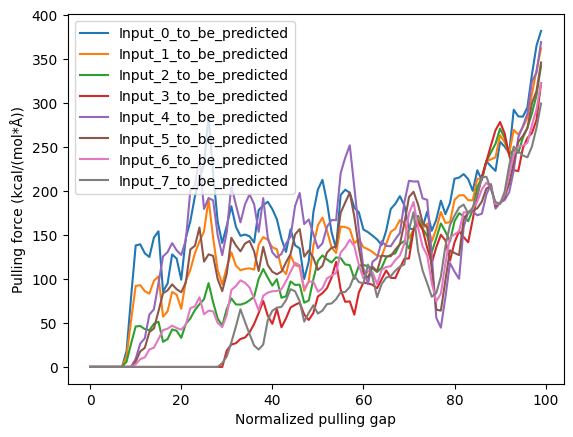

Now, make design based on the inputs...



Producing 8 samples...from image conditingig x_data  ...
Input contents:
cond_img condition: x_data=
 [array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        18.28863362,  80.0692019 , 138.13979123, 139.44611167,
       129.23179473, 124.99945748, 147.03594515, 154.26267409,
        85.748749  ,  94.74763505, 127.92603341, 123.13805332,
        99.12313939, 146.59346182, 165.770035  , 193.86780985,
       214.00913136, 230.90415894, 285.97514621, 220.28478982,
       165.21657777, 140.97041526, 160.604996  , 182.73803652,
       159.35024788, 149.0699255 , 150.54626136, 148.51384136,
       141.537062  , 178.25737158, 183.89341758, 187.809765  ,
       179.40302   , 167.89063924, 145.78564655, 130.70708892,
       156.36648317, 138.20652636, 134.73462406,  99.97278411,
       119.99524355, 175.66467083, 201.65559424, 212.72502818,
       187.39930591, 153.31598397, 

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

result dim:  torch.Size([8, 1, 128])


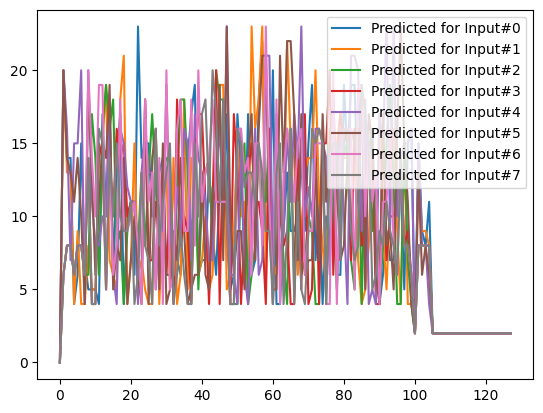

tensor([17, 20, 14, 14,  4,  6, 15,  7,  5,  5,  5,  4, 17, 10, 18,  6, 14, 17,
         4, 10, 11,  6, 23, 14, 15, 15, 10, 12, 13, 14,  6,  6,  5,  7,  6, 14,
        14, 17, 19,  6,  7,  7, 13,  9,  6, 12, 11, 17,  5,  6, 17, 13,  7, 17,
         6,  7, 18, 22,  9,  9, 20,  4,  4,  9, 13,  9,  9, 10, 14,  9, 15, 19,
         7, 11,  4, 10,  8, 15,  6,  6, 19, 14, 19, 19, 11,  8, 15, 14, 16,  8,
         4,  6,  9,  7,  7, 13, 12,  5, 15, 16, 12, 15,  9,  8, 11, 19, 20, 11,
        17, 11, 17, 17,  4, 17, 17, 17, 11, 11, 17, 17, 11, 17, 11, 11, 11,  4,
        17, 17], device='cuda:0')
tensor([ 5, 20, 13, 13,  4,  9,  4,  4,  8,  5,  5, 14, 15, 19,  7,  6,  5, 18,
        21,  4,  7, 15,  6,  7,  5,  4,  4, 16,  4, 10, 13,  5, 14,  4,  6, 18,
         5, 14, 13,  6,  7, 10,  5,  6, 12, 19, 19,  5,  6,  9, 15, 10, 11,  4,
        23, 16, 18, 23,  6, 16,  7,  6, 11,  9, 22, 15, 14,  6,  9, 13, 14, 14,
        20, 11,  8,  5, 16,  7, 15, 17, 14, 14,  7, 15,  7,  4,  5,  8, 15,  7,
      

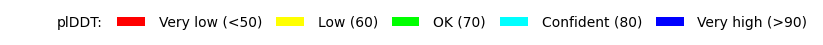

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

For None or [  0.           0.           0.           0.           0.
   0.           0.           0.          12.19242241  53.37946793
  92.09319415  92.96407444  86.15452982  83.33297166  98.02396343
 102.84178273  57.16583267  63.16509003  85.28402227  82.09203555
  66.08209293  97.72897455 110.51335667 129.24520657 142.67275424
 153.93610596 190.65009747 146.85652655 110.14438518  93.98027684
 113.26618295 130.32051743 115.21384005 109.95814935 111.50363362
 112.12047879 110.6379971  139.25401676 147.61078685 144.61681044
 135.93508952 133.8414882  112.20370803 105.51703962 126.78428185
 115.69128733 114.14739412  86.50069256  97.78519682 137.55264183
 161.15336059 169.76223629 154.79631037 136.03060112 129.56109911
 159.6066976  159.01942819 156.89666416 140.6024269  145.42806336
 136.13430188 133.84294094 130.63544912 126.44938608 125.60422528
 139.85916623 153.52631933 157.29334918 166.96625393 163.38836786
 146.11630993 156.10143063 169.23123586 157.99337498 162.88871136
 142.6

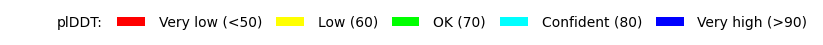

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

For None or [  0.           0.           0.           0.           0.
   0.           0.           0.           6.09621121  26.68973397
  46.04659708  46.48203722  43.07726491  41.66648583  49.01198172
  51.42089136  28.58291633  31.58254502  42.64201114  41.04601777
  33.04104646  48.86448727  55.25667833  64.62260328  71.33637712
  76.96805298  95.32504874  73.42826327  55.07219259  46.99013842
  65.92736991  77.90299834  71.07743223  70.84637321  72.46100588
  75.72711622  79.73893221 100.25066195 111.32815612 101.42385587
  92.46715904  99.79233715  78.62176951  80.32699031  97.20208053
  93.17604829  93.56016419  73.02860101  75.57515009  99.44061284
 120.65112694 126.79944441 122.19331483 118.74521827 124.54160458
 123.77376687 116.53844123 115.70150787 100.03291941 115.10884778
 116.02314094 114.4062116  112.00290186 107.94922252 112.72096816
 124.79318856 127.43090867 129.16717624 139.72227441 143.19194827
 134.74525926 155.67034575 166.79014264 157.04254663 149.13074061
 130.4

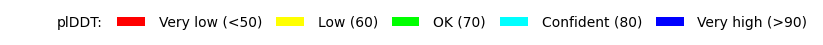

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

For None or [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  18.58855686  25.48547925  26.94102441  31.73459706  33.41837813
  39.33375364  48.83986731  61.24730713  75.04552539  58.23090131
  48.99922856  65.7431861   45.03983099  55.136941    67.61987922
  70.66080925  72.97293425  59.55650946  53.36510336  61.32858384
  80.14889329  83.83665252  89.59031929 101.45983542 119.52211005
  87.94083613  74.05745426  74.50635158  59.46341192  84.7896322
  95.91198     94.96948226  93.37035461  89.44905895  99.83771103
 109.72721088 101.335498   101.0410033  112.47829489 122.99552868
 123.37420859 155.23926086 164.34904941 156.09171827 135.37276985
 118.27814295 136.02938335 150.29986367 143.866

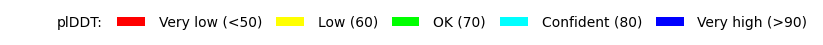

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

For None or [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   9.27057096  26.54325161  32.5554302   59.49383985  65.58182737
  94.97946124 125.65080824 130.55647234 140.80061923 132.49903576
 127.37946356 144.07248542 200.464899   206.64575955 237.81010773
 179.5995346  192.04419717 189.36722909 149.88939216 127.09089777
 153.42007661 206.35131813 184.30371571 164.364225   184.8689347
 196.21744172 185.04481182 153.61014611 191.94694882 147.0741948
 130.25460966 124.34208579 128.52320026 140.21746628 148.18491878
 183.14251236 197.79451611 162.39311768 167.68855773 151.08258755
 135.10781402 140.50282485 159.39732598 167.07470514 166.84084773
 220.38885444 237.85354439 251.91188864 204.56819692 154.77669828
 111.97948161  94.20822286 119.62747544 123.74786709 142.97415182
 137.69756637 137.19539833 145.24797377 152.19872016 187.46783712
 211.66722222 210.7918396  210.97535091 191.64797271 190.01925235
 127.43434203  5

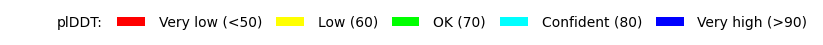

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

For None or [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   6.18038064  17.69550107  21.70362013  39.6625599   43.72121825
  63.31964083  83.76720549  87.03764823  93.86707948  88.33269051
  84.91964237  96.04832362 133.643266   137.7638397  158.54007182
 119.73302306 128.02946478 126.24481939  99.92626144  86.19053866
 106.25796065 146.85641052 138.16980691 131.41424297 140.29466116
 143.25754436 131.45513646 109.00282189 136.47003305 115.78635783
 108.14243125 105.36097671 108.44487496 118.76502212 128.27123785
 150.75957305 156.75180697 125.42971761 132.3285796  124.09035396
 110.31183834 115.02704091 130.07409655 135.44295943 136.90451979
 175.24579763 186.96733497 198.23176191 170.97988051 135.34519846
 106.30833253 101.60572945 113.72758411 108.94513264 126.72900313
 125.65212069 125.86405356 133.31257967 139.48830926 163.82529414
 193.09548724 199.17855928 184.66060856 164.23424105 158.39025542
 111.57124681 

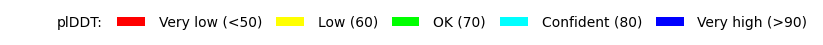

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

For None or [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   3.09019032   8.84775054  10.85181007  19.83127995  21.86060912
  31.65982041  41.88360275  43.51882411  46.93353974  44.16634525
  42.45982119  48.02416181  66.821633    68.88191985  79.27003591
  59.86651153  64.01473239  63.1224097   49.96313072  45.29017954
  59.09584469  87.36150291  92.03589811  98.46426093  95.72038761
  90.297647    77.8654611   64.39549767  80.99311728  84.49852087
  86.03025285  86.37986763  88.36654966  97.31257797 108.35755693
 118.37663373 115.70909783  88.46631754  96.96860147  97.09812037
  85.51586266  89.55125697 100.75086712 103.81121372 106.96819185
 130.10274081 136.08112556 144.55163518 137.39156409 115.91369864
 100.63718344 109.00323604 107.82769277  94.14239818 110.48385445
 113.606675   114.53270878 121.37718556 126.77789836 140.18275116
 174.52375226 187.56527896 158.34586621 136.82050939 126.76125848
  95.70815159 

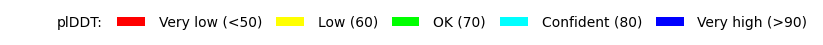

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

For None or [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           4.38982043
  11.93372874  27.8665953   45.90198931  65.5142789   51.14611407
  37.33774964  24.27578573  19.78817346  25.51620151  53.2106839
  63.91807445  67.39875855  68.28822436  75.86013382  88.443876
  85.99369441  74.6663887   51.50291747  61.60862334  70.10588677
  60.71988698  64.07547303  71.42763769  72.17946801  77.03186391
  84.959684    85.19491614  90.87150845 103.80324768  96.48219882
  94.96603436 116.40074264 101.92780143  79.33966373  94.23870577
 101.56122932 103.201364   109.44179145 114.06748745 116.54020818
 155.95201727 175.95199864 132.03112386 109.40677773  95.13226155
  79.84505636  83.984695   102.6944665  1

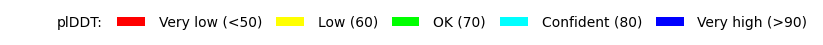

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
#@title ### Example:

#@markdown Generate protein candidates for the given unfolding force vecters


Sample_for_the_first_N_inputs = 8 #@param {type:"slider", min:1, max:8, step:1}




#
if CKeys['Working_Mode']==2:
    if TestKeys['Sample_On_DeNovo']:
        #
        print("Run sampling on De Novo inputs set...")
        #
        # de novo test
        if CKeys['Problem_ID']==2 or CKeys['Problem_ID']==6 \
        or CKeys['Problem_ID']==11:
            print('Loading back a common de novo tests: ')
            import pickle
            pk_save_de_novo_list = this_working_path+'0_dataprocess_MD/ForTest_LE_128_From_F1_f5.pt'

            with open(pk_save_de_novo_list, 'rb') as handle:
                de_novo_test_condition_list = pickle.load(handle)

            de_novo_test_condition_list = de_novo_test_condition_list[:8]
            print("Get de novo tests #: ", len(de_novo_test_condition_list))


        elif CKeys['Problem_ID']==3:
            pass
        elif CKeys['Problem_ID']==4:
            pass

        elif CKeys['Problem_ID']==5:
            pass





if CKeys['Working_Mode']==2:
    #
    if TestKeys['Sample_On_DeNovo']:


        if CKeys['Problem_ID']==2:
            pass

        elif CKeys['Problem_ID']==3:
            pass
        #
        elif CKeys['Problem_ID']==4:
            pass

        elif CKeys['Problem_ID']==5:
            pass
        #
        elif CKeys['Problem_ID']==6:
            pass


        #
        elif CKeys['Problem_ID']==7:
            pass

        elif CKeys['Problem_ID']==8:
            pass

        elif CKeys['Problem_ID']==11:
            # plot the input
            print("On the inputs:")
            fig = plt.figure(figsize=(24,16),dpi=200)
            fig, ax0 = plt.subplots()
            for ii in range(Sample_for_the_first_N_inputs):
              ax0.plot(
                  de_novo_test_condition_list[ii],
                  label='Input_'+str(ii+0)+'_to_be_predicted'
                  )

            plt.legend()
            plt.xlabel('Normalized pulling gap')
            plt.ylabel('Pulling force (kcal/(mol*Å))')
            plt.show()
            plt.close()
            # conduct inferring
            print("Now, make design based on the inputs...")
            print("\n\n")
            DeNovoSam_pdbs, DeNovoSam_fasta = \
            TrainerPack.sample_sequence_omegafold_pLM_ModelB_For_ForcPath (
                working_model,
                x_data=de_novo_test_condition_list[:Sample_for_the_first_N_inputs], # [:2],
                flag=100, #last_epoch, # flag="DeNovo", # ,
                cond_scales=[1.],
                foldproteins=True, # foldproteins,
                # ++++++++++
                ynormfac=DataKeys['ynormfac'],
                train_unet_number=1, # train_unet_number,
                tokenizer_X=tokenizer_X,
                Xnormfac=DataKeys['Xnormfac'],
                max_length=DataKeys['max_AA_seq_len'], # max_length,
                prefix=PKeys['prefix'], # prefix,
                tokenizer_y=tokenizer_y,
                # ++
                CKeys=CKeys,
                sample_dir=TestKeys['test_dir'], # sample_dir,
                steps=100, # last_step,
                e=100, # last_epoch,
                IF_showfig= True, # CKeys['SlientRun']!=1,
                # ++
                pLM_Model=pLM_Model,
                pLM_Model_Name=pLM_Model_Name,
                image_channels=DataKeys['image_channels'],
                pLM_alphabet=esm_alphabet,
            )

